# Fast two-peak von Mises fit

The two-peak von Mises to fit to data points 
$$x = \begin{pmatrix}x_0\\ \vdots \\ x_{N-1}\end{pmatrix}$$ 
measured at uniformly distributed locations 
$$\varphi = \begin{pmatrix} \varphi_0 \\ \vdots \\ \varphi_{N-1} \end{pmatrix} \quad \varphi_k = \frac{2k\pi}{N}$$

is defined as 
$$ v = a_0 + a_1 g(\varphi) + a_2 g(\varphi-\pi)$$
where
$$g(\varphi) = e^{-w\left(1+\cos(\varphi - \theta)\right)}$$
The fit has five scalar parameters $a_0$, $a_1$, $a_2$, $w$, and $\theta$.



## Step 1. Remove offset and orthogonalize basis:
The least-squares fit will not be affected if both the data and the fitted functions have zero mean.  Subtracting the mean is a fast operation that does not affect the other parameters.  Therefore, let's modify the fitted functions as:
$$\dot g(\varphi) = g(\varphi) - \bar g$$ where $\bar g = \sum\limits_{k=0}^{N-1} g(\varphi_k)$ and fit the function 
$$v=a_1 \dot g(\varphi) + a_2 \dot g(\varphi-\pi) = a^\top G$$ with $$a=\begin{pmatrix}a_1 \\ a_2 \end{pmatrix}$$ and 
$$G = \begin{pmatrix} \dot g_1^\top(\varphi) \\ \dot g_2^\top(\varphi)\end{pmatrix}$$
to the data $\dot x_k = x_k-\bar x$ where $\bar x = \sum\limits_{k=0}^{N-1}x_k$.

The least squares fit is then $$\hat a = G^\dagger \dot x$$

The pseudo-inverse matrix $$G^\dagger(\theta, w)= \left(G G^\top \right)^{-1} G$$ is independent of $x$ and can be precomputed for a set of values of $w$ and $\theta$ to.

## Step 2: Optimize for preferred direction
Optimization for preferred direction is a convex problem when the sharpness is low or when the solution is close.  Therefore, we begin with low sharpness and optimize for preferred direction $\theta$ first and for sharpness $w$ simultaneous but at a slow conservative rate.

The initial estimate of $\theta$ can be computed quickly by measuring the circular mean of the doubled angle.  
$$\theta_0 = \tfrac 1 2 \arg \left(x^T e^{2 i \varphi}\right)$$
When the underlying data are well fitted with a 2-peak von Mises, this estimate will already approach the optimal value.  We will only assume that it is within 8$^\circ$ of the optimum and perform binary search.  Binary search with 1-degree precision will therefore take three steps.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# von Mises formulas
def g(c, w):
    return exp(-w*(1-c))

def von(phi, a0, a1, a2, theta, w):
    c = cos(phi-theta)
    return a0 + a1 * g(c, w) + a2 * g(-c,w)

In [3]:
def fit(phi, x):

    # estimate theta with two-cosine fit
    s = np.dot(x, exp(2j*phi))
    theta = 0.5*angle(s)
    xm = x.mean()
    x -= xm
    c = cos(phi-theta)

    def amps(width):
        # fit amplitudes
        G = np.stack((g(c, width), g(-c, width)))
        gm = G.mean(axis=1, keepdims=True)
        a = maximum(x @ pinv(G-gm), 0)
        d = x - a @ (G-gm)
        return d@d, a, gm, sign(d @ (a @ (G * np.stack((1-c, 1+c)))))
    
    # binary search for optimal width
    best = None
    bounds = [0, fit.nwidths]
    while bounds[1]-bounds[0] > 1:
        mid = (bounds[0]+bounds[1])//2
        candidate = amps(fit.widths[mid])
        if best is None or best[0]>candidate[0]:
            best = candidate
        bounds[1 if candidate[3]>0 else 0] = mid
        
    _, a, gm, _ = best
                
    if a[0]<a[1]:
        a = a[[1,0]]
        theta = theta + pi

    return xm-a@gm, a[0], a[1], theta % (2*pi), w

fit.nwidths = 64  # make a power of two
fit.widths = logspace(0, 1, fit.nwidths, base=30.0)

In [4]:
# model
N = 18

theta = 293/180 * pi
w = 3.5
a0 = 0.5
a1 = 3.0
a2 = 1.2

# data
phi = r_[0:2*pi:2*pi/N]
sigma = 0.1
random.seed(3)
x = von(phi, a0, a1, a2, theta, w) + np.random.randn(*phi.shape)*sigma

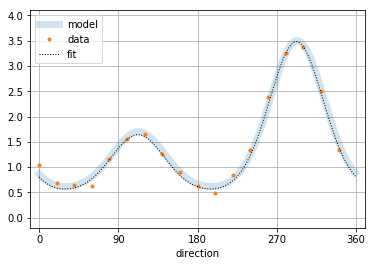

In [5]:
# plot fit results
t = r_[0:2*pi:pi/180]
plot(t/pi*180, von(t, a0, a1, a2, theta, w), lw=7, alpha=0.2)
plot(phi*180/pi, x, '.')

xticks(r_[0:361:90])
xlabel('direction')
grid('on')
xlim(-10, 370)
ylim(-2*sigma, a0 + a1*(1+maximum(sigma, 0.05)*2));

plot(t*180/pi, von(t, *fit(phi, x)), lw=1, c='k', ls=':')

legend(('model', 'data', 'fit'));

In [6]:
%timeit fit(phi, x)

668 µs ± 3.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
